In [2]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import seaborn as sns
sns.set()
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
#Program that executes the rolling window train-val-test split 
%run /data/workspace_files/TimeBasedCV.ipynb

In [4]:
#Read in the cleansed and winsorised data
df = pd.read_csv('/data/workspace_files/cleaned.csv', parse_dates =["eom"])
df.drop('date', axis=1, inplace=True)
df['eom'] = pd.to_datetime(df['eom'])
#Convert to float 32 (format needed for the most ML models)
cols_to_front = ['permno', 'eom', 'ret_excess']
df = df[cols_to_front + [c for c in df.columns if c not in cols_to_front]]
df[df.columns[3:]] = df[df.columns[3:]].astype('float32')
#Sort observations by date and stock id
df = df.sort_values(by = ['eom', 'permno'], ascending = True)
df.head()

,permno,eom,ret_excess,mvel1,beta,betasq,chmom,dolvol,idiovol,indmom,...,securedind,sin,baspread,ill,maxret,retvol,std_dolvol,std_turn,zerotrade,sic2
0,10006,1959-07-31,0.064813,71077.250,1.186630,1.408090,-0.189153,9.754356,0.025758,0.434433,...,0.0,0.0,0.013859,1.956238e-07,0.020151,0.013405,0.474575,0.513313,1.056137e-07,37.0
1,10014,1959-07-31,-0.000025,9723.375,1.687401,2.847321,0.112981,8.221681,0.069418,0.434433,...,0.0,0.0,0.037710,2.040267e-06,0.100000,0.036694,0.520349,0.916624,6.106661e-08,35.0
2,10022,1959-07-31,-0.008954,21210.000,1.022527,1.045561,0.146052,8.734319,0.041049,0.434433,...,0.0,0.0,0.026405,8.405795e-07,0.052083,0.025663,1.192576,4.492107,2.310417e-08,35.0
3,10030,1959-07-31,0.105999,83415.000,1.232348,1.518681,-0.038157,9.981096,0.023733,0.434433,...,0.0,0.0,0.016875,6.822973e-07,0.029557,0.016014,1.192576,1.285815,9.657306e-08,35.0
4,10057,1959-07-31,-0.016352,30625.000,1.209462,1.462798,0.088590,8.784775,0.030906,0.434433,...,0.0,0.0,0.008054,3.425895e-07,0.055319,0.014424,1.009791,1.615000,1.909091e+00,35.0


### Rank standardization  in interval [-1,1]

A rank standardization procedure following Kelly, Pruitt, and Su (2019) and Freyberger, Neuhierl, and Weber (2020) is employed. The stock characteristics are ranked month-by-month cross-sectionally and the ranks are mapped into the [-1,1] interval, thereby transforming features into a uniform distribution and increasing the insensitivity to outliers

In [5]:
#Standardize all independent variables
features = df.columns[~df.columns.isin(["eom",'permno',"ret_excess"])].tolist()

#Ranks in [0,1]interval
df[features]=df.groupby("eom")[features].rank(pct=True)

#Multiply by 2 and substract 1 to get ranks in interval [-1,1] 
df[features] = 2*df[features] - 1

In [6]:
df["permno2"] = df["permno"].copy()
df["eom2"] = df["eom"].copy()
df = df.set_index(['eom2','permno2'])
df.head()

permno 
 eom 
 ret_excess 
 mvel1 
 beta 
 betasq 
 chmom 
 dolvol 
 idiovol 
 indmom 
 ... 
 securedind 
 sin 
 baspread 
 ill 
 maxret 
 retvol 
 std_dolvol 
 std_turn 
 zerotrade 
 sic2 
 
 
 eom2 
 permno2 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 1959-07-31 
 10006 
 10006 
 1959-07-31 
 0.064813 
 0.043802 
 0.308481 
 0.308481 
 -0.215284 
 0.258155 
 -0.371855 
 0.000932 
 ... 
 0.000932 
 0.000932 
 -0.204101 
 -0.295433 
 -0.638397 
 -0.282386 
 -0.658900 
 0.168686 
 -0.356943 
 0.616962 
 
 
 10014 
 10014 
 1959-07-31 
 -0.000025 
 -0.830382 
 0.817335 
 0.817335 
 0.774464 
 -0.573159 
 0.977633 
 0.000932 
 ... 
 0.000932 
 0.000932 
 0.951538 
 0.785648 
 0.944082 
 0.953402 
 -0.500466 
 0.524697 
 -0.647717 
 -0.024231 
 
 
 10022 
 10022 
 1959-07-31 
 -0.008954 
 -0.561976 
 0.075489 
 0.075489 
 0.822926 
 -0.325256 
 0.632805 
 0.000932 
 ... 
 0.000932 
 0.000932 
 0.759553 
 0.461323 
 0.587139 
 0.783784 
 0.990680 
 0.972041 
 -0.947810 
 -0.024231 
 
 
 10030 
 10030 
 1959-07-31 
 0.105999 
 0.118360 
 0.375582 
 0.375582 
 0.405405 
 0.394222 
 -0.524697 
 0.000932 
 ... 
 0.000932 
 0.000932 
 0.148183 
 0.347623 
 -0.152842 
 0.062442 
 0.990680 
 0.699907 
 -0.397950 
 -0.024231 
 
 
 10057 
 10057 
 1959-07-31 
 -0.016352 
 -0.392358 
 0.347623 
 0.347623 
 0.731594 
 -0.302889 
 0.120224 
 0.000932 
 ... 
 0.000932 
 0.000932 
 -0.800559 
 -0.002796 
 0.658900 
 -0.155638 
 0.908667 
 0.789376 
 0.639329 
 -0.024231 
 
 
 
 5 rows × 31 columns

# Elastic Net Model

### Formula:

$\phi(\theta ; \lambda, \rho)=\lambda(1-\rho) \sum_{j=1}^{P}\left|\theta_{j}\right|+\frac{1}{2} \lambda \rho \sum_{j=1}^{P} \theta_{j}^{2}
$

### Hyperparameters:
- overall strength of the penalty, $\lambda \in(0,1)$
- $\rho \in(0,1)$, regulating the weight of the lasso and ridge penalization, where $p=0$ corresponds to the lasso and $p=1$ to the ridge method. Here $\rho$ is set to $0.5 .$ 

- In sklearn the $\lambda$ parameter is called  **alpha** and $\rho $ is called **l1_ratio**
## All firms

In [7]:
# Define the splitting scheme:
# Rolling window  train-val-test split
# The rolling window is set to 96 months (8 years)
# 5 years for training, 2 years for validation, and 1 year for out-of-samlpe testing
tscv = TimeBasedCV(train_period=60,
                   val_period=24,
                   test_period=12,
                   freq='months')

#define the idependent variables (X) and the dependent variable (y)
features = df.columns[~df.columns.isin(['eom', 'permno',"ret_excess"])].tolist()
X = df[features]
y = df["ret_excess"]

#Empty containers to save results from each window
predictions = []
y_test_list =[]
dates = []
dic_r2_all = {}

# Model’s complexity: dictionary to save the number of characteristics over time
num_coef_time = {}

# List of values to use for the alpha hyperparameter
alphas = np.linspace(start=0.00001,stop=0.004,num=20)
# Empty container to save the objective loss function (mean squared errors) for each alpha
mse = np.full((len(alphas),1),np.nan, dtype = np.float32)


for train_index, val_index, test_index in tscv.split(df, first_split_date= datetime.date(1965,12,31), second_split_date= datetime.date(2020,1,31), date_column="eom"):

    X_train   = X.loc[train_index]
    y_train = y.loc[train_index]
    
    X_val   = X.loc[val_index]
    y_val = y.loc[val_index]

    X_test    = X.loc[test_index]
    y_test  = y.loc[test_index]
    
    #Loop over the list containing potential alpha values, fit on the training sample and use 
    #validation set to generate predictions
    for i in range(len(alphas)):
        model_val = ElasticNet(alpha=alphas[i], l1_ratio=0.5)
        model_val.fit(X_train,y_train)
        Yval_predict = model_val.predict(X_val)
        #calculate mean squared error for each potential value of the alpha hyperparameter
        mse[i,0] = np.sqrt(mean_squared_error(y_val,Yval_predict))
 
    #The optimal value of the alpha hyperparameter is the value that causes the lowest loss
    optim_alpha = alphas[np.argmin(mse)]
   
    #Fit again using the train and validation set and the optimal alpha parameter
    model = ElasticNet(alpha=optim_alpha, l1_ratio=0.5)
    model.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))
    #Use test set to generate final predictions 
    preds = model.predict(X_test)

    #Save predictions, dates and the true values of the dependent variable to list  
    predictions.append(preds)
    dates.append(y_test.index)
    y_test_list.append(y_test)
    
    #Calculate OOS model performance the for current window
    r2 = 1-sum(pow(y_test-preds,2))/sum(pow(y_test,2))
    #Save OOS model performance and the respective month to dictionary
    dic_r2_all["r2." + str(y_test.index)] = r2
    # Save the number of characteristics to inspect  model's complexity over time 
    num_coef = len(model.coef_[np.nonzero(model.coef_ != 0)])
    num_coef_time["ncoef." + str(y_test.index)] = num_coef
   
        
#Concatenate to get results over the whole OOS test period (Jan 2010-Dec 2019)
predictions_all= np.concatenate(predictions, axis=0)
y_test_list_all= np.concatenate(y_test_list, axis=0) 
dates_all= np.concatenate(dates, axis=0)

#Calculate OOS model performance over the entire test period in line with Gu et al (2020)
R2OOS_ENet = 1-sum(pow(y_test_list_all-predictions_all,2))/sum(pow(y_test_list_all,2))
print("R2OOS Elastic net: ", R2OOS_ENet)

Train period: 1960-12-31 - 1965-12-31 ,val period: 1965-12-31 - 1967-12-31 , Test period 1967-12-31 - 1968-12-31 # train records 70919 ,# val records 41209 , # test records 13008
Train period: 1961-12-31 - 1966-12-31 ,val period: 1966-12-31 - 1968-12-31 , Test period 1968-12-31 - 1969-12-31 # train records 83549 ,# val records 32603 , # test records 17740
Train period: 1962-12-31 - 1967-12-31 ,val period: 1967-12-31 - 1969-12-31 , Test period 1969-12-31 - 1970-12-31 # train records 91319 ,# val records 30748 , # test records 18674
Train period: 1963-12-31 - 1968-12-31 ,val period: 1968-12-31 - 1970-12-31 , Test period 1970-12-31 - 1971-12-31 # train records 87957 ,# val records 36414 , # test records 16997
Train period: 1964-12-31 - 1969-12-31 ,val period: 1969-12-31 - 1971-12-31 , Test period 1971-12-31 - 1972-12-31 # train records 86909 ,# val records 35671 , # test records 23194
Train period: 1965-12-31 - 1970-12-31 ,val period: 1970-12-31 - 1972-12-31 , Test period 1972-12-31 - 197

### Time-varying model complexity

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.]),
 [Text(-10.0, 0, '2010-12-31'),
  Text(0.0, 0, '1968-01-31'),
  Text(10.0, 0, '1978-01-31'),
  Text(20.0, 0, '1987-12-31'),
  Text(30.0, 0, '1997-12-31'),
  Text(40.0, 0, '2007-12-31'),
  Text(50.0, 0, '2018-01-31'),
  Text(60.0, 0, '')])

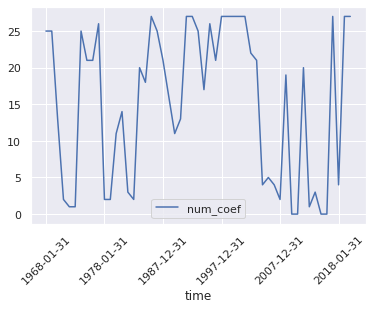

In [21]:
# Convert dictionary containing the number of characterictics over time in dataframe
pd.DataFrame(num_coef_time.items())
num_coef =pd.DataFrame(num_coef_time.items(), columns=['Identifier', 'num_coef'])
num_coef['Identifier'] = num_coef['Identifier'].astype(str)
num_coef["time"] = num_coef["Identifier"].str[20:30]
num_coef.drop(["Identifier"], axis = 1, inplace = True)

#Plot time-varying model complexity
num_coef.set_index('time').plot()
plt.xticks(rotation=45)

In [22]:
#Save the model's complexity  to compare with other models later.
num_coef.to_csv('comp_enet.csv')

In [29]:
#Generate a results dataframe containing the model predictions (yhat) and the true values (y_true) 
#of the dependent variable for each stock in each month

yhat = predictions_all.tolist()
y_true = y_test_list_all.tolist()
i = dates_all.tolist()

results = pd.DataFrame(
    {'identifier': i,
     'yhat': yhat,
     'y_true': y_true
    })

results['date'] = results['identifier'].str[0]
results['id'] = results['identifier'].str[1]
results.drop(["identifier"],axis = 1, inplace=True)
results['date'] = pd.to_datetime(results['date'], format='%Y-%m-%d')
results['MonthYear'] = results['date'].dt.to_period('M')
results = results.sort_values(by = ['date', 'id'], ascending = True)
results = results.set_index(['MonthYear','id'])
results.head()

yhat 
 y_true 
 date 
 
 
 MonthYear 
 id 
 
 
 
 
 
 
 
 1968-01 
 10006 
 0.013291 
 -0.041823 
 1968-01-31 
 
 
 10014 
 0.017077 
 0.087460 
 1968-01-31 
 
 
 10030 
 0.019243 
 0.034743 
 1968-01-31 
 
 
 10057 
 0.028924 
 0.017201 
 1968-01-31 
 
 
 10065 
 0.014072 
 -0.011992 
 1968-01-31

In [30]:
# Save results to use for Diebold-Mariano test
enet= results.reset_index()
enet.to_csv('enet.csv', index = False)